# Reinforcement learning with spiking neural networks

In [1]:
# @title Install prerequisites
#!pip3 install matplotlib gym --quiet
#!pip3 install git+https://github.com/norse/norse --quiet
#!pip3 install git+https://github.com/ncskth/norse-rl --quiet

%matplotlib inline
#%config InlineBackend.close_figures=False 

# Setup environment
import gym
import norse_rl
env = gym.make("Gridworld-v0")

# Setup simulation
from norse_rl import simulate
simulation = simulate.Simulation(env)
run = simulation.run

# Import neuron simulator
import torch
import norse.torch as norse
from norse_rl.util import Linear

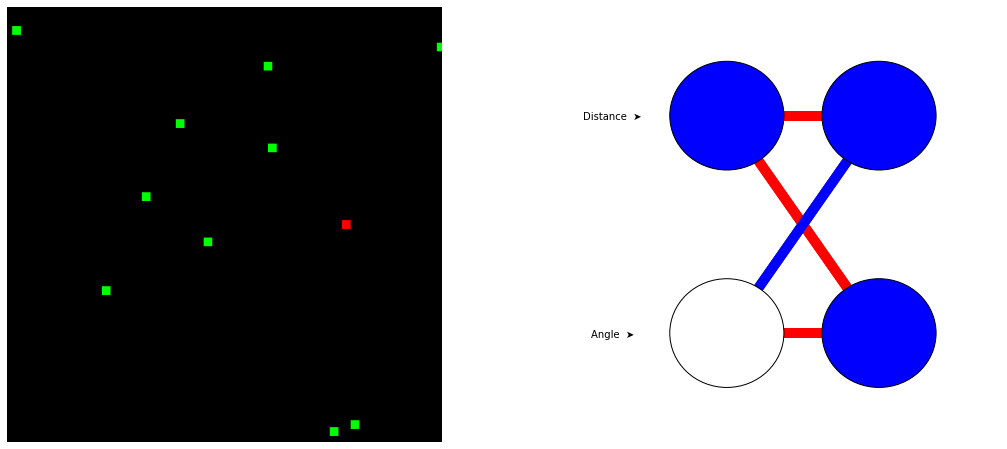

In [2]:
w = [ [1, -1] 
    , [1,  1]
    ]

model = norse.SequentialState(
    norse.LIFCell(),
    Linear(2, 2, w),
    norse.LIFCell(),
)

run(model)